## importando a base de dados nescessaria

In [6]:
!pip install mlforecast
!pip install lightgbm
!pip install xgboost

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import List
import pickle

import mlforecast
from mlforecast import MLForecast

from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

from utilsforecast.plotting import plot_series

import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from mlforecast import MLForecast
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

### Funções

In [8]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

## Importando a base de dados

In [9]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [10]:
data = pd.read_parquet(bucket_uri)

In [11]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [12]:
data['id'].nunique()

30490

In [13]:
data['item_id'].nunique()

3049

In [14]:
data['dept_id'].nunique()

7

In [15]:
data['cat_id'].nunique()

3

In [16]:
data['store_id'].nunique()

10

In [17]:
data['state_id'].nunique()

3

In [18]:
data['date'] = pd.to_datetime(data['date'])

In [19]:
data = data.set_index('date')

## Previsão do item (item_id)✅


In [20]:
df_item_id = data.groupby(['item_id']).resample('M')['value'].sum()

In [21]:
df_item_id.to_frame()

value
item_id         date             
FOODS_1_001     2011-01-31     16
                2011-02-28    304
                2011-03-31    309
                2011-04-30    279
                2011-05-31    365
...                           ...
HOUSEHOLD_2_516 2016-01-31     45
                2016-02-29     44
                2016-03-31     45
                2016-04-30     40
                2016-05-31     34

[198185 rows x 1 columns]

In [22]:
df_item_id_reset_index = df_item_id.reset_index()

In [23]:
df_nixtla_2 = pd.DataFrame({
    'unique_id': df_item_id_reset_index['item_id'],
    'ds': df_item_id_reset_index['date'],
    'y': df_item_id_reset_index['value']
})

In [24]:
df_nixtla_2.head(3)

,unique_id,ds,y
0,FOODS_1_001,2011-01-31,16
1,FOODS_1_001,2011-02-28,304
2,FOODS_1_001,2011-03-31,309


In [25]:
df_nixtla_2['ds'] = pd.to_datetime(df_nixtla_2['ds'])

In [26]:
df_nixtla_2['unique_id'].value_counts().sum()

198185

In [27]:
df_test = df_nixtla_2.groupby('unique_id').tail(6)
df_train = df_nixtla_2.drop(df_test.index)

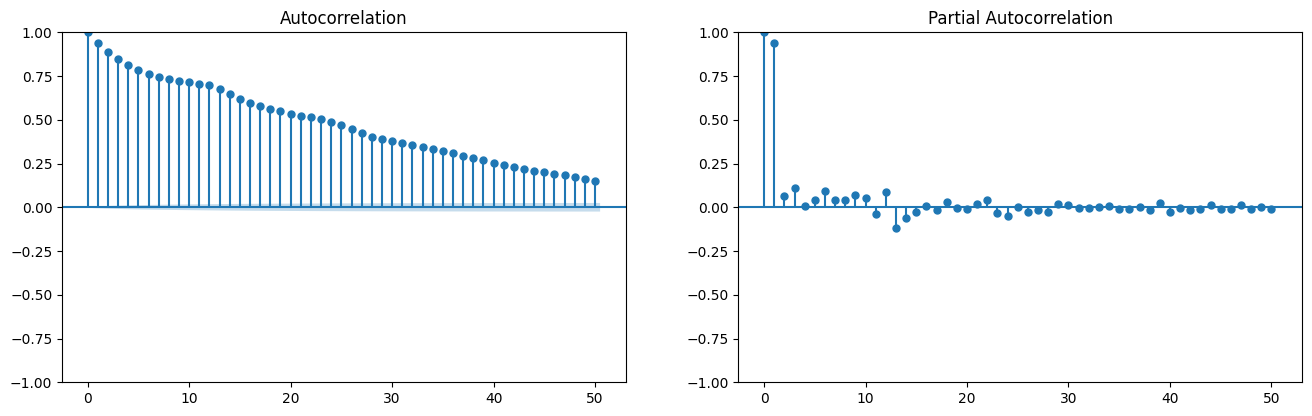

In [28]:
acf_pacf(df_train['y'], 50)

In [29]:
class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

In [30]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'MLPRegressor': MLPRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    "naive": Naive()
}

In [31]:
fcst = MLForecast(
    models=models,
    freq='M',
    lags=[x for x in range(1, 10)],
)

In [32]:
fcst.fit(df_train, id_col='unique_id', time_col='ds', target_col='y')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 152450, number of used features: 9
[LightGBM] [Info] Start training from score 351.397632


MLForecast(models=[RandomForestRegressor, LinearRegression, MLPRegressor, KNeighborsRegressor, XGBRegressor, LGBMRegressor, naive], freq=M, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9'], date_features=[], num_threads=1)

In [33]:
len(df_test)

18294

In [34]:
predict = fcst.predict(6)

In [35]:
for i in list(models.keys()):
  predict[i] = predict[i].astype(int)

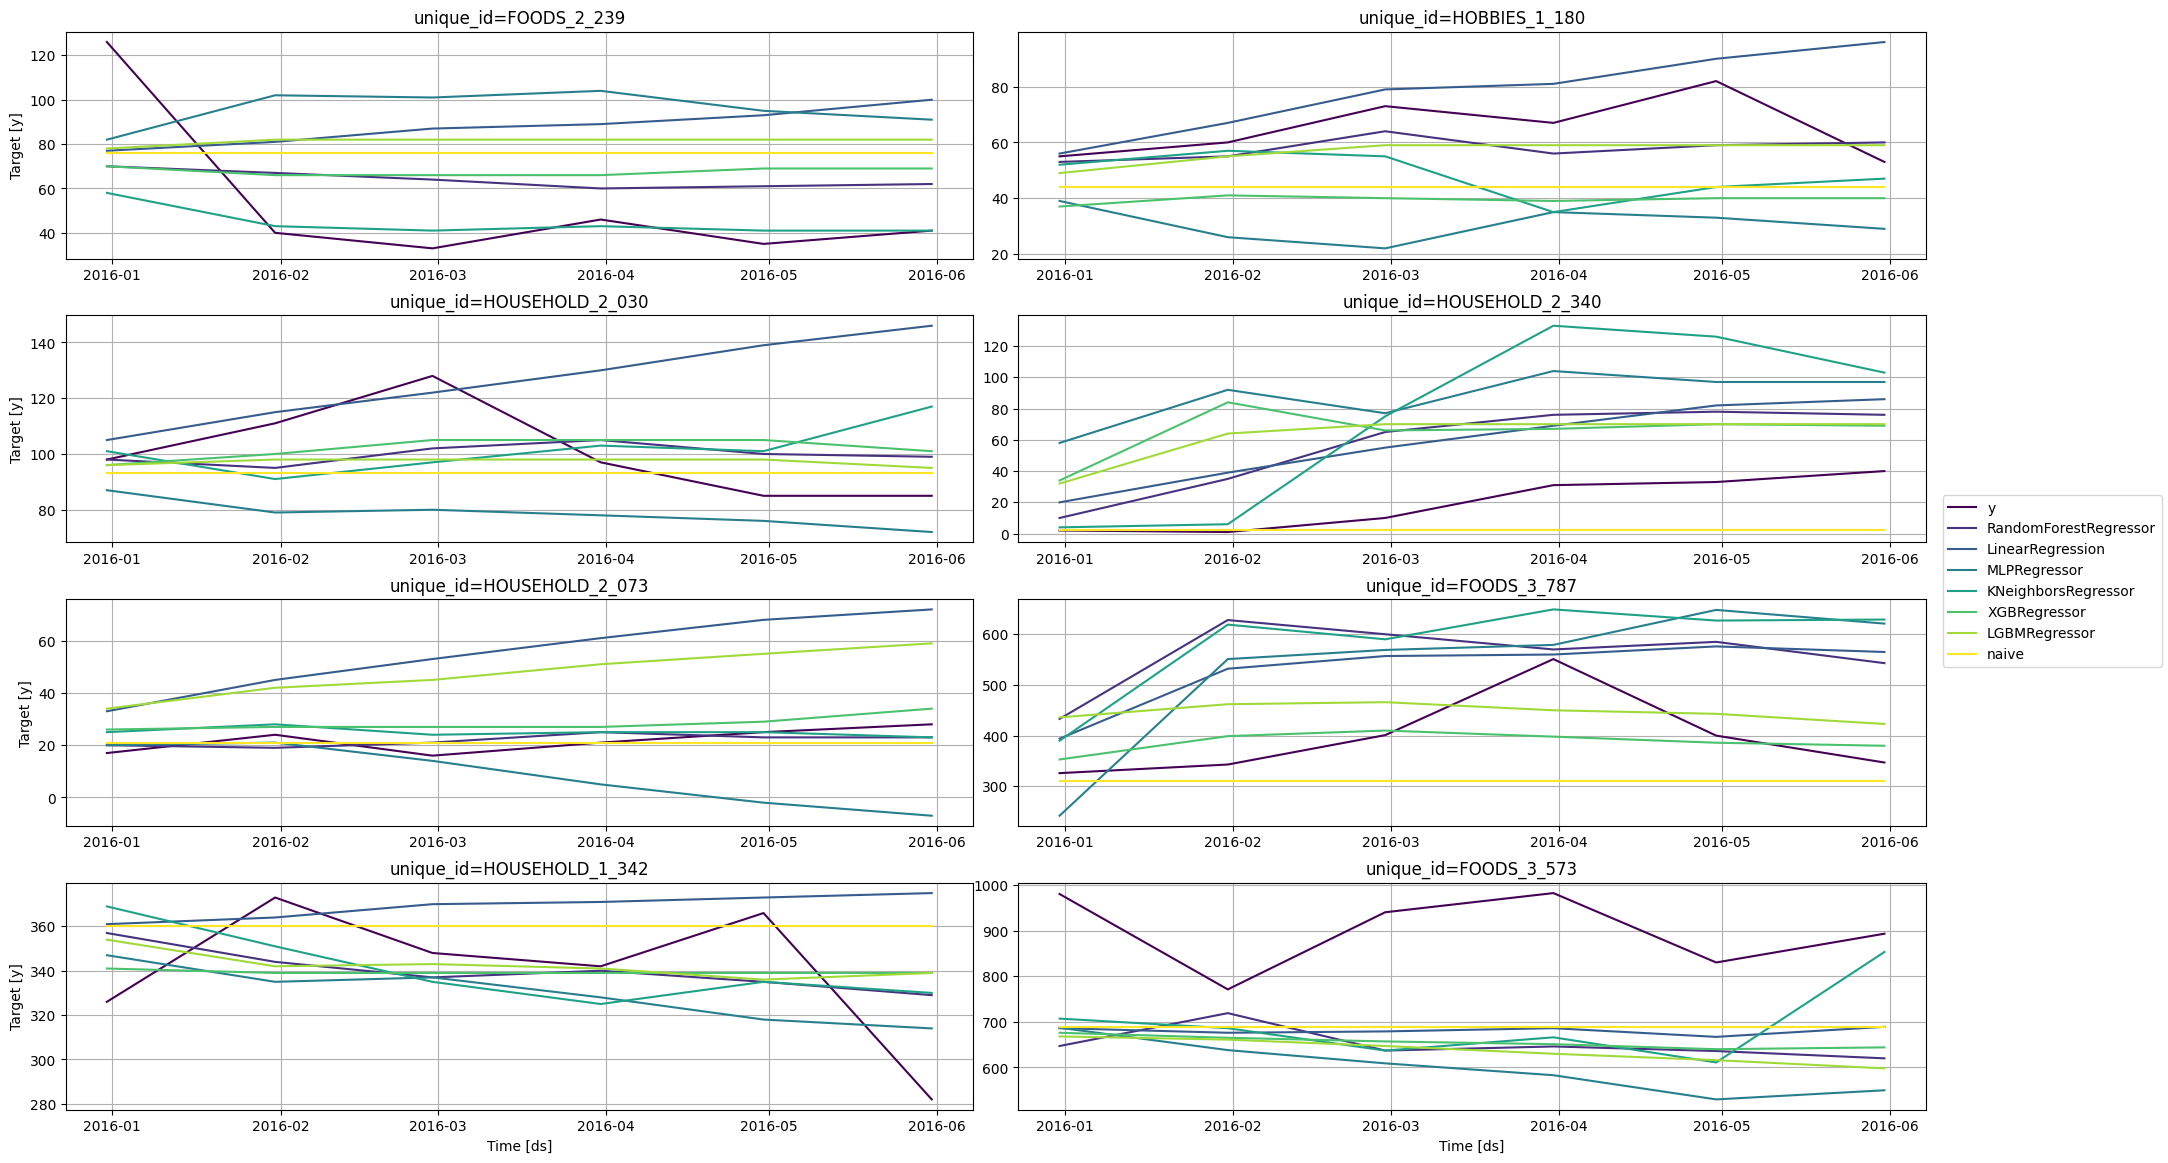

In [36]:
plot_series(df_test, predict)

In [37]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], predict[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], predict[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(df_test['y'], predict[i]))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], predict[i])
  print(f'R2: {R2}')
  print('\n')

------------------RandomForestRegressor-----------------
Mean Absolute Error: 97.24062534164207
Mean absolute percentage error: 1.322400028334213e+16
Root mean squared error: 260.9655721466935
R2: 0.8602178284486013


------------------LinearRegression-----------------
Mean Absolute Error: 103.42052038919864
Mean absolute percentage error: 1.0899085290399802e+16
Root mean squared error: 265.8838153981855
R2: 0.8548994182133061


------------------MLPRegressor-----------------
Mean Absolute Error: 115.68957035093473
Mean absolute percentage error: 1.3718327825255324e+16
Root mean squared error: 328.33881168641636
R2: 0.7787263022660273


------------------KNeighborsRegressor-----------------
Mean Absolute Error: 103.60741226631683
Mean absolute percentage error: 1.3054382914627892e+16
Root mean squared error: 277.0893948583667
R2: 0.8424112692249455


------------------XGBRegressor-----------------
Mean Absolute Error: 103.2752815130644
Mean absolute percentage error: 1.3602869848583368

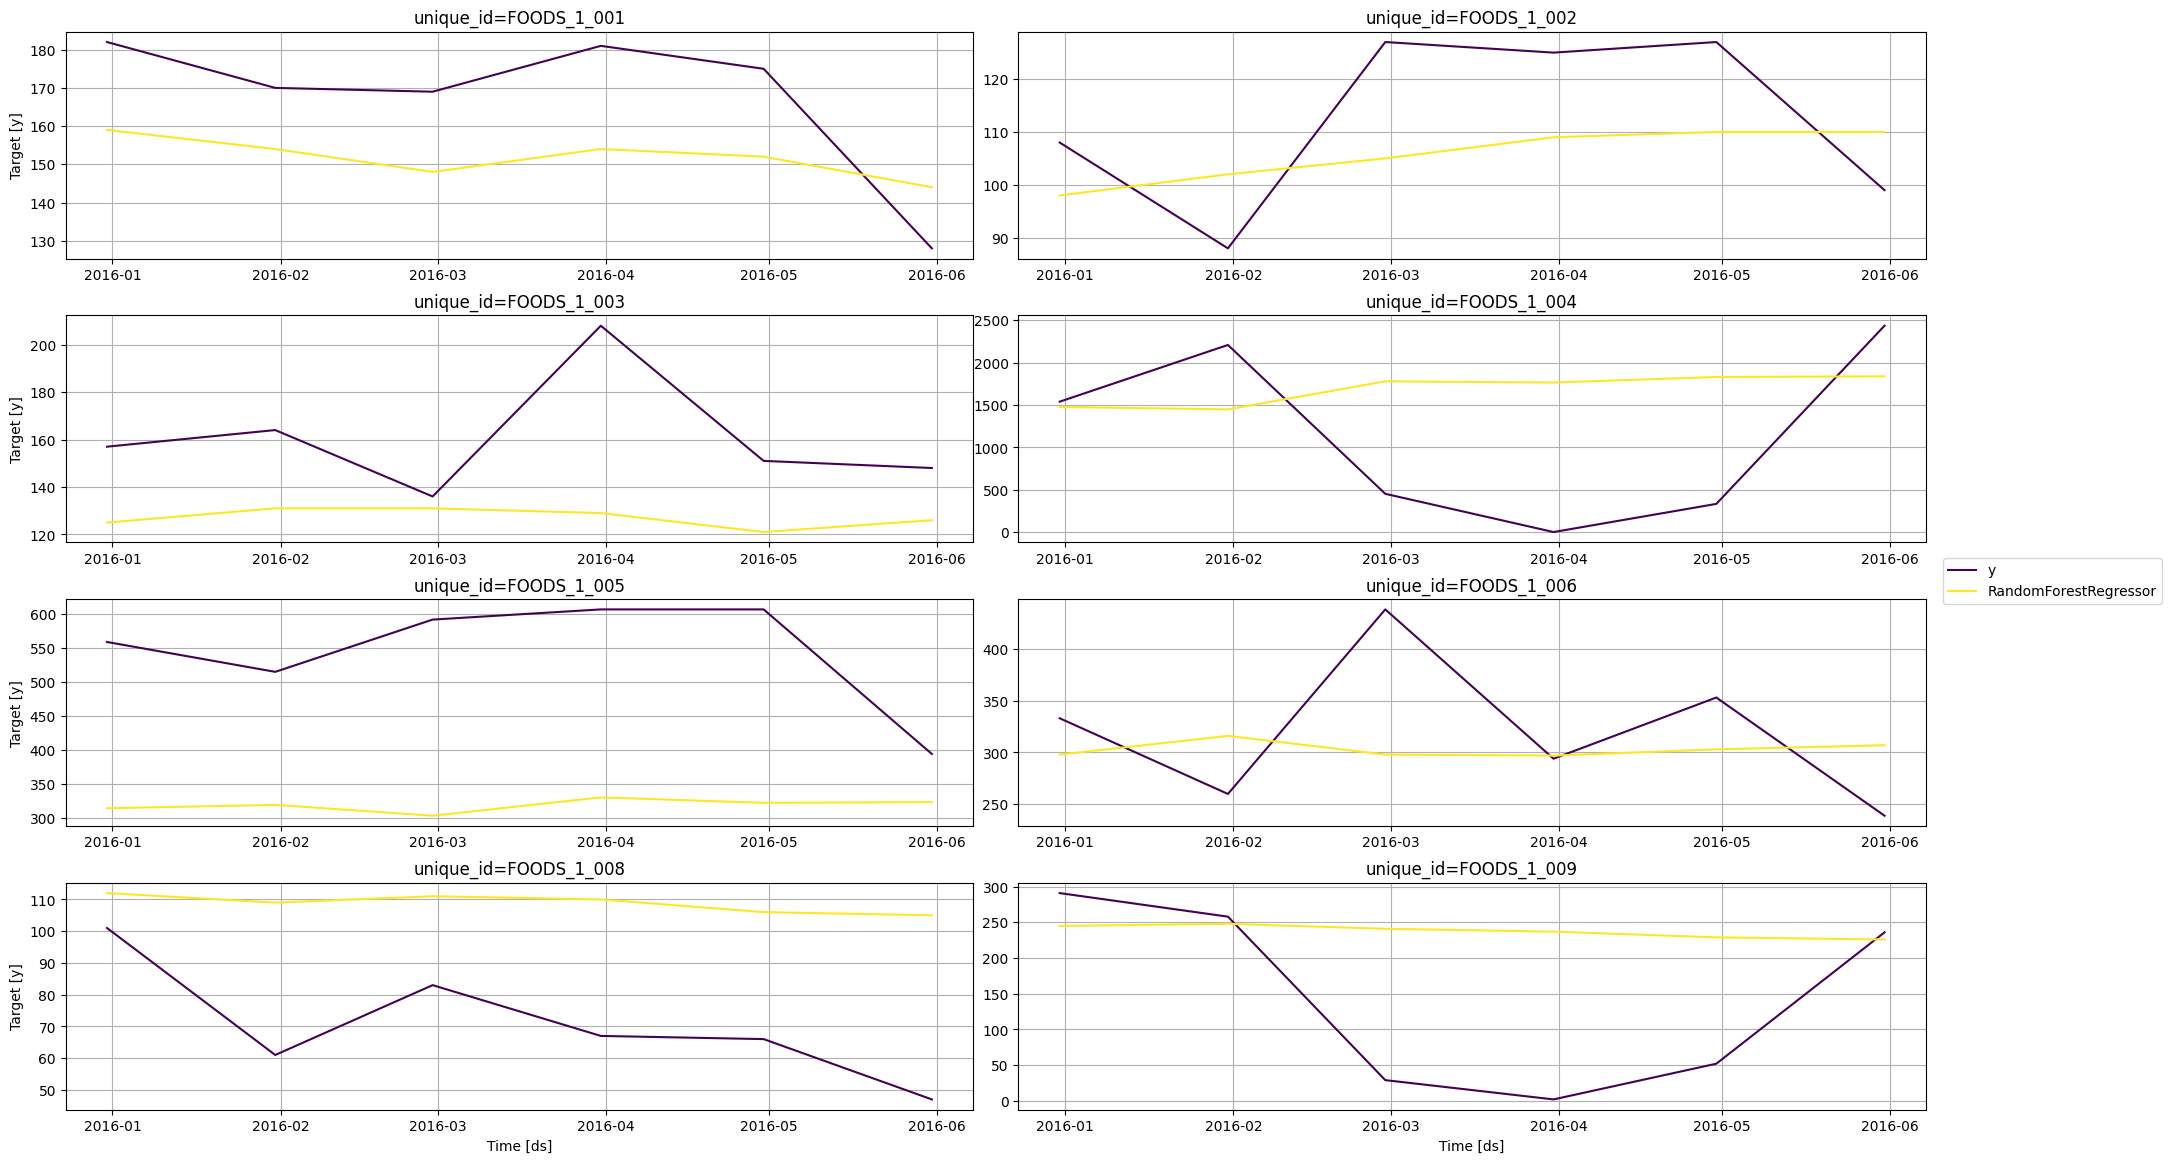

In [41]:
plot_series(df_test, predict[['unique_id', 'ds', 'RandomForestRegressor']], plot_random=False)

In [42]:
previsao = df_test.merge(predict, how='right', on=['unique_id', 'ds'])
previsao.head()

,unique_id,ds,y,RandomForestRegressor,LinearRegression,MLPRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor,naive
0,FOODS_1_001,2015-12-31,182,159,169,151,135,161,153,157
1,FOODS_1_001,2016-01-31,170,154,175,141,132,161,144,157
2,FOODS_1_001,2016-02-29,169,148,178,137,123,161,143,157
3,FOODS_1_001,2016-03-31,181,154,185,134,132,163,143,157
4,FOODS_1_001,2016-04-30,175,152,191,133,135,163,143,157


In [40]:
previsao.to_csv('treinamento/treino_item_treino.csv')

Treinando o melhor modelo

In [43]:
models = {
    'RandomForestRegressor' : RandomForestRegressor()
}

fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 6, 12]
)

dados_full = pd.concat([df_train, df_test])
fcst.fit(dados_full)

MLForecast(models=[RandomForestRegressor], freq=MS, lag_features=['lag1', 'lag6', 'lag12'], date_features=[], num_threads=1)

In [44]:
previsao = fcst.predict(6)
previsao['RandomForestRegressor'] = previsao['RandomForestRegressor'].astype(int)
previsao

,unique_id,ds,RandomForestRegressor
0,FOODS_1_001,2016-06-01,165
1,FOODS_1_001,2016-07-01,145
2,FOODS_1_001,2016-08-01,142
3,FOODS_1_001,2016-09-01,162
4,FOODS_1_001,2016-10-01,163
...,...,...,...
18289,HOUSEHOLD_2_516,2016-07-01,43
18290,HOUSEHOLD_2_516,2016-08-01,39
18291,HOUSEHOLD_2_516,2016-09-01,45
18292,HOUSEHOLD_2_516,2016-10-01,41


In [45]:
import pickle
with open('Modelosprevisao_item.pkl', 'wb') as file:
    pickle.dump(fcst, file)

In [46]:
previsao.to_csv('previsao/previsao_itens_RandomForestRegressor.csv')